# Example: Controllability Analysis (Part 1)

- Author: Parker Smith
- Date: 12/29/2025

## Introduction

This problem is formulated to introduce the controllability capabilities of `DyMAD`. This example shows how, starting with training data, one can transfer to latent space, train a model, and conduct controllability analyses all within the local architecture.

In this example, we again look at a simple damped pendulum. However, this time, we take it one step further by considering a control opportunity.

## Problem

Let the states be $x = [x_1, x_2]$, where $x_1 = \theta$ is the angular displacement and $x_2 = \dot{\theta}$ is the angular velocity. In state-space form, the true dynamics is

$$
\begin{aligned}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= -\frac{g}{l}\left( \sin(x_1) + \frac{1}{10} x_2 \right) + u
\end{aligned}
$$

where the parameter $u$ represents the control input of the system, in this case a simple torque application.



First, we need to train the model. We begin with some imports:



In [1]:
# Import packages:
from funcs import *
import time
import torch
from dymad.io import load_model, DataInterface
from dymad.models import KBF, DKBF, DKMSK
from dymad.training import NODETrainer, LinearTrainer
from dymad.utils import animate, compare_contour, plot_summary, plot_trajectory, setup_logging, plot_multi_trajs

Next, we process the data for model training:


In [2]:
# Load and process data:
raw = np.load("./data/pendulum_data.npz")
dat = np.moveaxis(raw['states'], 1, 0)
ctrl = np.moveaxis(raw['controls'], 1, 0)

# Reshape:
Nt, Nx, Nn = dat.shape
_, Nu, _ = ctrl.shape
X = np.transpose(dat, (2, 0, 1))
U = np.transpose(ctrl, (2, 0, 1))
ts = np.arange(Nt)

# Split data into training and testing and save:
n_sample = 450
np.savez_compressed(
    './data/pendulum.npz',
    x=X[:n_sample],
    t=ts,
    u=U[:n_sample],
)
np.savez_compressed(
    './data/test.npz',
    x=X[n_sample:],
    t=ts,
    u=U[n_sample:],
)

Model options:

In [3]:
def gen_mdl_kb(e, l, k):
    return {
        "name" : 'pend_ctrl',
        "encoder_layers" : e,
        "decoder_layers" : e,
        "latent_dimension" : l,
        "koopman_dimension" : k,
        "activation" : "prelu",
        "weight_init" : "xavier_uniform",
        "predictor_type" : "linear"
    }

Training options:

In [4]:
trn_ln = {
    "n_epochs": 500,
    "save_interval": 50,
    "load_checkpoint": False,
    "ls_update": {
        "method": "full"}
    }
crit = {
    "dynamics" : {"weight" : 1.0},
    "recon" : {"weight" : 1.0}}

Training model: `kbf_node`

> Continuous-time Koopman model, SVD as observables, using least squares and finite difference (for $\dot{z}$) to estimate system matrix and NODE to refine the matrix.


In [5]:
# Train model:
config_path = 'pendulum.yaml'
mdl = 'dkbf_ln'
MDL = DKBF
Trainer = LinearTrainer
opt = {"model" : gen_mdl_kb(0, 0, 2), "training" : trn_ln, "transform_x" : []}
opt["model"]["name"] = f"kp_{mdl}"
trainer = Trainer(config_path, MDL, config_mod=opt)
trainer.train()

Verify by plotting true vs predicted results for a given control sequence:

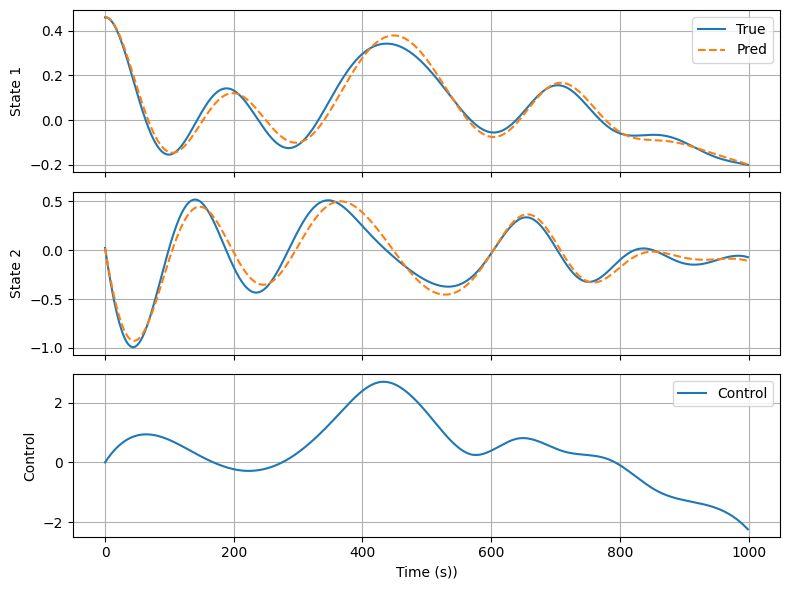

In [6]:
# Load test data:
dat = np.load('./data/test.npz')
x_data, t_data, u_data = dat['x'], dat['t'], dat['u']
res = [x_data]

# Predict trajectory using model and test controls:
model, prd_func = load_model(MDL, f'kp_{mdl}.pt')
with torch.no_grad():
    pred = prd_func(x_data, t_data, u=u_data)
res.append(pred)

# Plot results against actual trajectory:
i = 22
x_true = res[0]
x_pred = res[1]
traj_true = x_true[i]
traj_pred = x_pred[i]
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for j in range(2):
    axes[j].plot(traj_true[:, j], label='True')
    axes[j].plot(traj_pred[:, j], '--', label='Pred')
    axes[j].set_ylabel(f'State {j+1}')
    axes[j].grid(True)
axes[0].legend()
axes[2].plot(u_data[i, :], label='Control')
axes[2].set_ylabel('Control')
axes[2].set_xlabel('Time (s))')
axes[2].grid(True)
axes[2].legend()
plt.tight_layout()

Next, we will check and the accuracy of the system matrices:

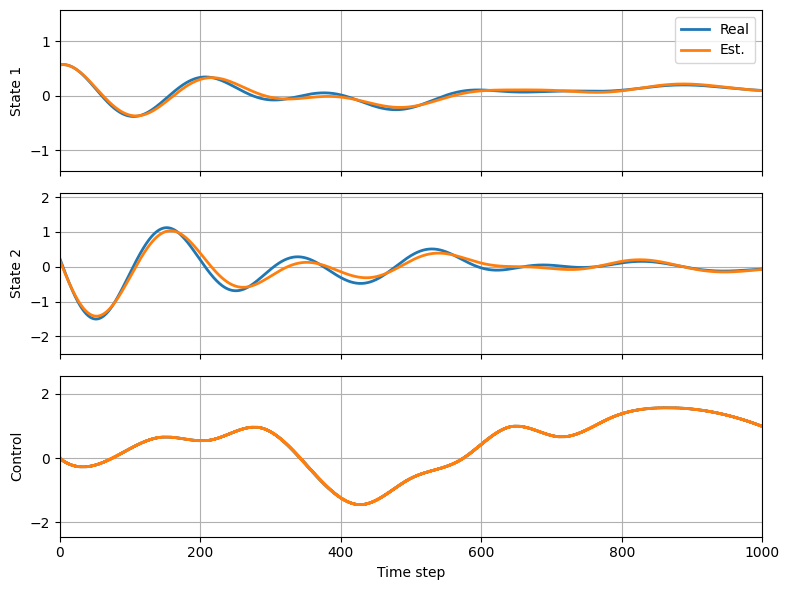

In [7]:
# Get system matrices linearized around equilibrium (trim) condition:
x_ref = np.array([0, 0])
u_ref = np.array([0])
A, B, C = linearize(model, x_ref)

# Grab the first matrices:
A = A[0]
B = B[0]
C = C[0]

# Pick random test point:
test = np.load('./data/test.npz')
x_test, t, u_test = test['x'], test['t'], test['u']
i = 40
x_real = x_test[i, :, :].T
u_real = u_test[i, :, :].T

# Get simulated trajectory from system matrix and compare against true results:
n_tsteps = 1000
x_est, z_traj = prop_dyn_latent(model, A, B, C, x_real[:, 0], u_real[:, :].T, use_C=False)
plot_traj(np.stack([x_real, x_est[1:, :].T], axis=-1), u_real.T, n_tsteps, lab=['Real', "Est."])

In the above code, you might have realized the `use_C` option in the `prop_dyn_latent()` function. This allows the user to estimate the decoding by using the linearized observation matrix, $C$ (as opposed to using the full model decoder). To verify this, we will compare the results of two nominal trajectories, one of which uses $C$ and the other using the full model decoder.

In [8]:
# Define problem:
n_tsteps = 1000
x_0 = np.array([0, 0]).T
u_seq = u_test[i, :, :] # Grab a test control sequence from above

# Propagate with full decoder:
x_full, z_full = prop_dyn_latent(model, A, B, C, x_0, u_seq, use_C=False)

# Propagate with linear C approximation:
x_linear, z_linear = prop_dyn_latent(model, A, B, C, x_0, u_seq, use_C=True)

# Compute errors:
decoding_error = np.linalg.norm(x_full - x_linear, axis=1)
print(f'Max error: {np.max(decoding_error)}')

Max error: 0.0


In the above example, the `use_C` function is quite trivial; there is no encoding/decoding layers, so C is an identity matrix. However, it is still important to verify that the functionality works

Now, we must perform the controllability and stability analysis; these can be directly found from the model, but with an important caveat. Recall that we are working in an elevated (latent) space. That means that any linearized dynamics (e.g. A, B) occur within the latent space, not the real space. Therefore, the Controllability Gramian can be representative of the latent space but does not necessarily translate to full controllability in the real space. As such, we will also define a real (observation) space controllability matrix to directly verify controllability in the observation space.

> **Controllability Gramian (Latent Space)**: For a discrete-time linear system with dynamics $z_{k+1} = A z_k + B u_k$, the controllability Gramian $W_c$ is:
>
> $W_c = \sum_{i=0}^{\infty} A^i B B^T (A^T)^i$
>
> For stable systems (all eigenvalues of A have magnitude < 1), this can be solved algebraically using the discrete Lyapunov equation:
>
> $A W_c A^T - W_c + B B^T = 0$
>
> The latent space is controllable if $W_c$ is full rank, meaning we can reach any latent state through control inputs.
>
> **Real-Space Controllability Matrix**: To check if the observation space $x_k = C z_k$ is controllable, we compute the C-augmented controllability matrix:
>
> $\mathcal{C}_{obs} = C \cdot [B, AB, A^2B, \ldots, A^{n-1}B] = [CB, CAB, CA^2B, \ldots, CA^{n-1}B]$
>
> The real (observation) space is fully controllable if $\text{rank}(\mathcal{C}_{obs}) = n_x$ (the observation dimension). This directly checks whether we can reach any observation state through the composition of latent dynamics and the encoding dynamics.

In [9]:
# Check for stability:
n_tsteps = 500
eigs = np.linalg.eigvals(A)

# Calculate Controllability matrix & Gramian for latent space:
Ctrl, W = controllability(A, B, n_tsteps)
rank_Wc = np.linalg.matrix_rank(W)

# Check real-space controllability using C-augmented controllability matrix:
Ctrl_obs = rs_controllability(A, B, C, n_tsteps)
rank_obs = np.linalg.matrix_rank(Ctrl_obs)


# Print results for stability:
if np.all(abs(eigs) < 1):
    print("SYSTEM IS STABLE")
else:
    print("SYSTEM IS UNSTABLE")

# Print results for controllability:
if rank_Wc == A.shape[0] and rank_obs == C.shape[0]:
    print(f"LATENT AND REAL SPACE ARE CONTROLLABLE")
elif rank_Wc == A.shape[0] and rank_obs != C.shape[0]:
    print(f"LATENT SPACE IS CONTROLLABLE, BUT REAL SPACE IS NOT CONTROLLABLE")
else:
    print(f"NEITHER THE REAL OR LATENT SPACE ARE CONTROLLABLE")

SYSTEM IS STABLE
LATENT AND REAL SPACE ARE CONTROLLABLE


To show the versatility and power of the Controllability Gramain, lets analyze the optimal trajectory according to the controllability Gramian. We will plot this against the Riccati optimal solution to this trajectory.
> **Riccati-based Optimal Control**: The standard Riccati approach utilizes a stage cost where controls and states are both accounted for in the objective. However, this is fundamentally different from the Controllability approach, which simply minimizes the energy from the control cost. Therefore, to match the formulations, we will stage the Riccati equation as an optimization problem given by
>
> $\begin{aligned}
 \min_{u} \quad & \sum_{k=0}^{N-1} u_k^T R u_k  \\
\text{s.t.} \quad & x_{k+1} = A x_k + B u_k, \quad k=0,\ldots,N-1 \\
& x_0 = x_0  \\
& x_N = x_f
\end{aligned}$
>
> where, to mimic controllability-like behavior, we set $Q \approx 0$, which reduces the optimization problem to only  minimize control energy. This should allow us to analyze an analytical approach (i.e. controllability) and an optimization problem (i.e. our manipulated Riccati equation), verifying the accuracy between the two while differentiating the computation time between the two.

Controllability control energy of 4579.018, endpoint error of 0.000, and elapsed time of 0.008
Riccati control energy of 4580.459, endpoint error of 2.91e-06, and elapsed time of 0.956
Controllability is faster by a factor of 122.7!


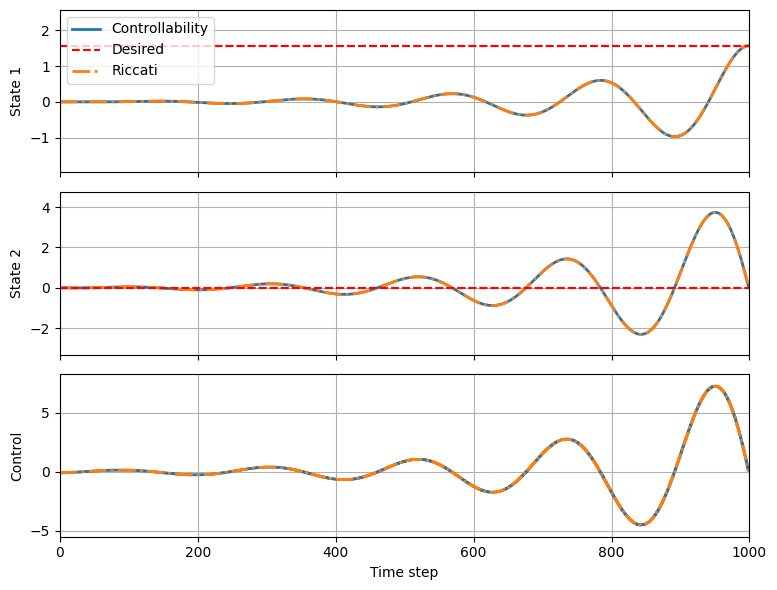

In [10]:
# Problem settings:
x_f = np.array([np.pi / 2, 0]).T
x_0 = np.array([0, 0]).T
n_tsteps = 1000

# Recompute controllability:
Ctrl, W = controllability(A, B, n_tsteps)

# Solve for control sequence using controllability:
start_time_ctr = time.time()
x_ctr, u_ctr = optimal_ctrl(A, B, C, model, Ctrl, W, n_tsteps, x_0, x_f, plot_graph=False)
end_time_ctr = time.time()
elapsed_ctr = end_time_ctr - start_time_ctr

# Define weights (now in latent space):
Q = 1e-8 * np.eye(A.shape[0])
R = np.eye(B.shape[1])
Pf = 1e2 * np.eye(A.shape[0])

# Solve for control sequence by optimizing the riccati equation:
start_time_ric = time.time()
x_ric, u_ric = riccati_opt(A, B, C, model, x_0, x_f, n_tsteps, Q, R, Pf)
end_time_ric = time.time()
elapsed_ric = end_time_ric - start_time_ric

# Plot trajectories (both are now in observation space):
plot_traj(np.stack([x_ctr[1:].T, x_ric[1:].T], axis=-1), np.stack([u_ctr, u_ric.T], axis=-1), n_tsteps, x_f, lab=['Controllability', "Riccati"], line=['-','-.'])
cost_ctr = np.sum(u_ctr**2)
cost_ric = np.sum(u_ric**2)
print(f"Controllability control energy of {cost_ctr:.3f}, endpoint error of {np.linalg.norm(x_ctr[-1, :] - x_f):.3f}, and elapsed time of {elapsed_ctr:.3f}")
print(f"Riccati control energy of {cost_ric:.3f}, endpoint error of {np.linalg.norm(x_ric[-1, :] - x_f):.2e}, and elapsed time of {elapsed_ric:.3f}")
print(f"Controllability is faster by a factor of {elapsed_ric / elapsed_ctr:.1f}!")

To further demonstrate this point, we can test the scalability -- i.e. what happens in really large trajectories with many more time steps:

In [ ]:
# Experiment settings:
x_0 = np.array([0.0, 0.0])
x_f = np.array([np.pi / 2, 0.0])

# n_tstep step values:
n_vals = [50, 100, 200, 500, 1000, 2000, 5000, 7000, 10000, 12500]

# Initialize lists:
time_ctr, time_ric = [], []

# Weights:
Q = 1e-8 * np.eye(A.shape[0])
R = np.eye(B.shape[1])
Pf = 1e2 * np.eye(A.shape[0])

# Sweep horizon lengths:
for n_tsteps in n_vals:

    # Controllability:
    t0 = time.time()
    Ctrl, W = controllability(A, B, n_tsteps)
    x_ctr, u_ctr = optimal_ctrl(A, B, C, model, Ctrl, W, n_tsteps, x_0, x_f, plot_graph=False)
    t1 = time.time()

    # Calculate controllability results:
    time_ctr.append(t1 - t0)

    # Riccati Optimization:
    t0 = time.time()
    x_ric, u_ric = riccati_opt(A, B, C, model, x_0, x_f, n_tsteps, Q, R, Pf)
    t1 = time.time()

    # Calculate Riccati results:
    time_ric.append(t1 - t0)

# Plot results:
plt.figure(figsize=(7, 6))

# Plot runtime vs number of time steps:
plt.loglog(n_vals, time_ctr, 'o-', label='Controllability')
plt.loglog(n_vals, time_ric, 's--', label='Riccati')

# Plot settings:
plt.ylabel("Runtime [s]")
plt.xlabel("Number of time steps")
plt.grid(True, which="both")
plt.legend()
plt.title("Scaling with trajectory length")
plt.tight_layout()

/Users/parkersmith/PycharmProjects/PennState/dymad-dev/examples/controllability/funcs.py:944: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  problem = cp.Problem(cp.Minimize(cost), constraints)
/Users/parkersmith/PycharmProjects/PennState/dymad-dev/examples/controllability/funcs.py:945: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  problem.solve(solver=cp.OSQP, verbose=False)


Which shows how runtime between the two exponentially increases as the number of timesteps increase -- meaning controllability performs significantly better than the optimal control problem. Furthermore, as also seen in the previous example, the accuracy holds up reasonably well, with negligible difference between the two (less than 0.1). Thus, for problems with large trajectories, controllability is a superior method in calculating the optimal control sequence.
> Also, recall that we are simply using the infinite sum (truncated at some point) for controllability. This means that, if A were to be stable, we can use the Lyapunov equation to get an even faster solution with the same (if not better) amount of accuracy!

Finally, to conclude our controllability analysis, we will demonstrate the robustness of such an approach by testing a range of final desired values to compare controllability and Riccati approaches:

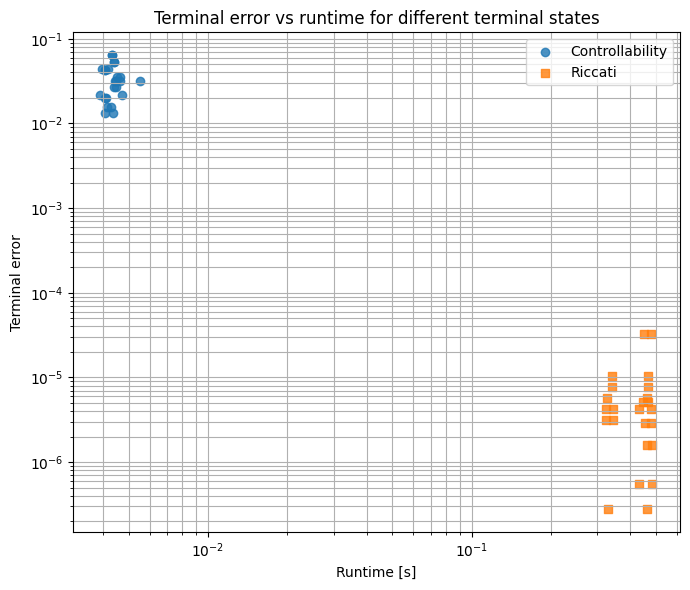

In [12]:
# Experiment settings:
x_0 = np.array([0.0, 0.0])
n_tsteps = 500

# Test range:
theta_vals = np.linspace(-np.pi, np.pi, 5)
omega_vals = np.linspace(-2.0, 2.0, 5)

# Initialize arrays:
err_ctr = np.zeros((len(theta_vals), len(omega_vals)))
err_ric = np.zeros_like(err_ctr)
time_ctr = np.zeros_like(err_ctr)
time_ric = np.zeros_like(err_ctr)

# Recompute controllability:
Ctrl, W = controllability(A, B, n_tsteps)

# Riccati weights:
Q = 1e-8 * np.eye(A.shape[0])
R = np.eye(B.shape[1])
Pf = 1e2 * np.eye(A.shape[0])

# Sweep space:
for i, theta in enumerate(theta_vals):
    for j, omega in enumerate(omega_vals):

        # Store final state:
        x_f = np.array([theta, omega])

        # Controllability:
        t0 = time.time()
        x_ctr, u_ctr = optimal_ctrl(A, B, C, model, Ctrl, W, n_tsteps, x_0, x_f, plot_graph=False)
        t1 = time.time()

        # Calculate controllability results:
        err_ctr[i, j] = np.linalg.norm(x_ctr[-1, :] - x_f)
        time_ctr[i, j] = t1 - t0

        # Riccati:
        t0 = time.time()
        x_ric, u_ric = riccati_opt(A, B, C, model, x_0, x_f, n_tsteps, Q, R, Pf)
        t1 = time.time()

        # Calculate riccati results:
        err_ric[i, j] = np.linalg.norm(x_ric[-1, :] - x_f)
        time_ric[i, j] = t1 - t0

# Plot results:
plt.figure(figsize=(7, 6))

# Plot controllability:
plt.scatter(
    time_ctr.flatten(),
    err_ctr.flatten(),
    marker='o',
    alpha=0.8,
    label='Controllability'
)

# Plot Riccati:
plt.scatter(
    time_ric.flatten(),
    err_ric.flatten(),
    marker='s',
    alpha=0.8,
    label='Riccati'
)

# Plot settings:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Runtime [s]")
plt.ylabel("Terminal error")
plt.title("Terminal error vs runtime for different terminal states")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()